In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

train = pd.read_csv('../data/train/train.csv')
train['DNI'] = train['DNI']*math.cos(math.pi/180*63)+train['DHI']
submission = pd.read_csv('../data/sample_submission.csv')
submission.set_index('id',inplace=True)

In [4]:
train['DHI'].describe()

count    52560.000000
mean        64.344121
std        103.897125
min          0.000000
25%          0.000000
50%          0.000000
75%         87.000000
max        528.000000
Name: DHI, dtype: float64

In [5]:
train['DNI'].describe()

count    52560.000000
mean       234.792371
std        349.684583
min          0.000000
25%          0.000000
50%          0.000000
75%        469.000000
max       1059.000000
Name: DNI, dtype: float64

In [50]:
def transform(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# x_col =['WS','RH','T','TARGET','GHI']
x_col = ['DNI','WS', 'RH', 'T', 'TARGET']
# x_col =['TARGET']
y_col = ['TARGET']
# train['GHI'] = train['DNI']*math.cos(math.pi/180*63)+train['DHI']
dataset = train.loc[:,x_col].values
label = np.ravel(train.loc[:,y_col].values)

past_history = 48 * 2
future_target = 48 * 2

### transform train
train_data, train_label = transform(dataset, label, 0, None, past_history,future_target, 1)
### transform test
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'../data/test/{i}.csv')
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

In [7]:
train_data = np.nan_to_num(train_data)

In [8]:
train_data.shape

(1091, 576)

In [9]:
train_label.shape

(1091, 96)

In [18]:
features

[0.9538077268838671,
 0.9548994252137358,
 0.9555541959149253,
 0.9559213662782423,
 0.9564385098671956,
 0.9564775882113533,
 0.9565560721204888,
 0.9568099672865769,
 0.9569521136649771,
 0.9569444392312075,
 0.9570400610288204,
 0.9572020071138879,
 0.9571551634664944,
 0.957221624614968,
 0.9574053976248523,
 0.9572366390280167,
 0.9573778159040539,
 0.9574155618099676,
 0.9573215529180678,
 0.9574241429902998]

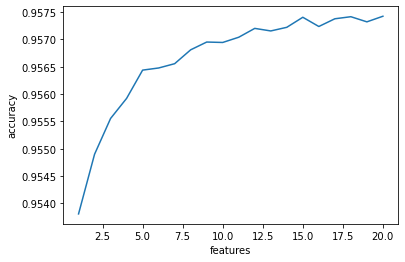

[0.9538077268838671, 0.9548994252137358, 0.9555541959149253, 0.9559213662782423, 0.9564385098671956, 0.9564775882113533, 0.9565560721204888, 0.9568099672865769, 0.9569521136649771, 0.9569444392312075, 0.9570400610288204, 0.9572020071138879, 0.9571551634664944, 0.957221624614968, 0.9574053976248523, 0.9572366390280167, 0.9573778159040539, 0.9574155618099676, 0.9573215529180678, 0.9574241429902998]


In [17]:
x = np.arange(1,21)
plt.xlabel("features")
plt.ylabel("accuracy")
plt.plot(x,features)
plt.show()
print(features)

In [ ]:
# feature testing = 15
from sklearn import ensemble
features = []
N_ESTIMATORS = 1000
for i in range(1,21):
    rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=i, random_state=0,
                                    max_depth = 20,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    features.append(rf.score(train_data, train_label))

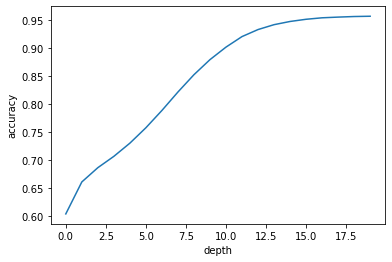

In [36]:
x = np.arange(0,20)
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.plot(x,depth)
plt.show()

In [38]:
for i in range(0,20):
    print(i, depth[i])

0 0.603252531499008
1 0.660501882103233
2 0.686093525425425
3 0.7063992480255471
4 0.7300106671168386
5 0.7576105518733333
6 0.7885928334832691
7 0.821641344680477
8 0.8526681480801258
9 0.8796617636717631
10 0.902107230142812
11 0.9209848595033495
12 0.9335679167448588
13 0.9423239389621626
14 0.9480615780109337
15 0.9519900964778566
16 0.9546399960838304
17 0.9558844630022175
18 0.9569248835771029
19 0.9574241429902998


In [ ]:
# max_depth test = 20
depth = []
N_ESTIMATORS = 1000
for i in range(1,21):
    rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=20, random_state=0,
                                    max_depth = i,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    print(rf.score(train_data, train_label))
    depth.append(rf.score(train_data, train_label))

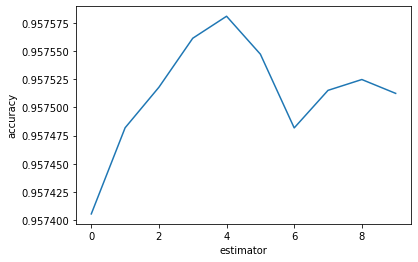

In [42]:
x = np.arange(10)
plt.xlabel("estimator")
plt.ylabel("accuracy")
plt.plot(x,estimator)
plt.show()

In [41]:
estimator

[0.9574053976248523,
 0.9574819444457304,
 0.9575179871033267,
 0.9575615049480733,
 0.9575810625633162,
 0.957547334918521,
 0.957481828585963,
 0.9575152069284435,
 0.9575248270284296,
 0.9575125189298781]

In [ ]:
# estimator test = 1500
estimator = []
# N_ESTIMATORS = 1000
for i in range(1000,2000,100):
    rf = ensemble.RandomForestRegressor(n_estimators=i,
                                    max_features=15, random_state=0,
                                    max_depth = 20,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    print(rf.score(train_data, train_label))
    estimator.append(rf.score(train_data, train_label))

In [51]:
# real modeling
from sklearn import ensemble
N_ESTIMATORS = 1500
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=15, random_state=0,
                                    max_depth = 20,
                                    verbose=True,
                                    n_jobs=-1)
rf.fit(train_data, train_label)
print("Clear")
rf_preds = []
for estimator in rf.estimators_:
#     print(estimator.predict(test).dtype)
    result = estimator.predict(test).astype(np.float64)
    rf_preds.append(result)
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    submission.iloc[:, i] = np.ravel(y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   17.8s finished


Clear


In [52]:
submission.to_csv(f'GHI.csv')

In [11]:
train_label.shape

(1091, 96)

In [12]:
train_data.shape

(1091, 96)